# Indoor temperature-based hysteresis control

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
outdoor_temp_series = df['Dry-bulb temperature (°C)']

In [3]:
# Define constants
desired_indoor_temp = 20.0  # Desired indoor temperature in °C
lower_threshold = 19.0      # Lower temperature threshold to turn on the heat pump
upper_threshold = 21.0      # Upper temperature threshold to turn off the heat pump

# Heat loss coefficient
K_SH = 0.02

# Heat pump max output heat power in kW
q_HP_max = 2
# Heat pump min output heat power in kW
q_HP_min = 0.35

# Time step in hours
delta_t = 0.5

# Building conditions
rho_in = 1.2041  # Air density in kg/m^3
c_in = 1000      # Specific heat capacity of air in J/(kg*K)
V_in = 3277      # Volume of the building in m^3

In [ ]:
# Initialize variables
heat_pump_on = False
heat_pump_on_series = []
heat_demand_profile = []

indoor_temp = desired_indoor_temp
indoor_temp_series = []

heat_pump_power_series = []

# Function to calculate heat loss
def calculate_heat_loss(K, indoor_temp, outdoor_temp):
    return K * (indoor_temp - outdoor_temp)

# Hysteresis control loop over time
for outdoor_temp in outdoor_temp_series:
    if indoor_temp < lower_threshold and not heat_pump_on:
        # Temperature below lower threshold - turn on the heat pump
        heat_pump_on = True
    elif indoor_temp > upper_threshold and heat_pump_on:
        # Temperature above upper threshold - turn off the heat pump
        heat_pump_on = False
    
    heat_loss = calculate_heat_loss(K_SH, indoor_temp, outdoor_temp)
    
    # Calculate heat demand
    if heat_pump_on:
        heat_demand = heat_loss
        q_HP = max(q_HP_min, q_HP_max * (desired_indoor_temp - indoor_temp)/(desired_indoor_temp - lower_threshold))
        
    else:
        heat_demand = heat_loss
        q_HP = 0
    
    # Update indoor temperature and add it to the series
    indoor_temp += ((q_HP - heat_loss)*delta_t*3.6e6)/(rho_in*V_in*c_in)
    indoor_temp_series.append(indoor_temp)
    # Append heat demand to profile
    heat_demand_profile.append(heat_demand)
    # Append heat pump on/off status to profile
    heat_pump_on_series.append(heat_pump_on)
    # Append heat pump power to profile
    heat_pump_power_series.append(q_HP)

In [5]:
# Create a DataFrame for visualization
results = pd.DataFrame({
    "Date": df['Date'],
    "Outdoor Temp (°C)": outdoor_temp_series,
    "Indoor Temp (°C)": indoor_temp_series,
    "Heat Pump On": heat_pump_on_series,
    "HP Power (kW)": heat_pump_power_series,
    "Heat Demand (kW)": heat_demand_profile
})

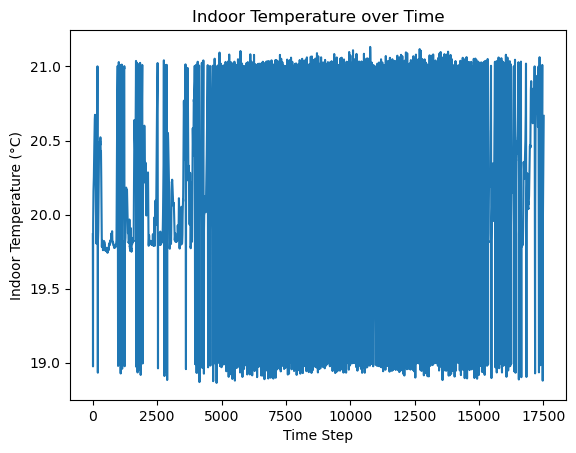

In [10]:
plt.plot(np.arange(17520), indoor_temp_series[:17520])
plt.xlabel('Time Step')
plt.ylabel('Indoor Temperature (°C)')
plt.title('Indoor Temperature over Time')
plt.show()

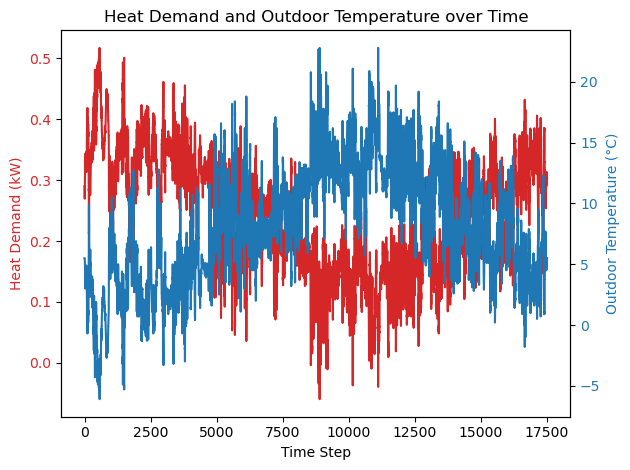

In [14]:
fig, ax1 = plt.subplots()

# Plot heat demand on primary y-axis
ax1.plot(np.arange(17520), heat_demand_profile[:17520], label='Heat Demand', color='tab:red')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Heat Demand (kW)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(np.arange(17520), outdoor_temp_series[:17520], label='Outdoor Temp', color='tab:blue')
ax2.set_ylabel('Outdoor Temperature (°C)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Heat Demand and Outdoor Temperature over Time')
fig.tight_layout()  # Adjust layout to make room for the second y-axis
plt.show()